In [1]:
using Distributions
using StatsPlots
default(fmt=:png)

function is_p_in_interval(p, interval)
    interval[begin] ≤ p ≤ interval[end]
end

interval1(k, n) = k/n - 0.9/√n, k/n + 0.9/√n

function interval_wald(k, n)
    p̂ = k/n
    p̂ - 1.96√(p̂*(1-p̂)/n), p̂ + 1.96√(p̂*(1-p̂)/n)
end

function interval_wilson(k, n)
    c = 1.96
    p̂ = k/n
    L = 1/(1+c^2/n) * (p̂ + c^2/(2n) - c*√(p̂*(1-p̂)/n + c^2/(4n^2)))
    U = 1/(1+c^2/n) * (p̂ + c^2/(2n) + c*√(p̂*(1-p̂)/n + c^2/(4n^2)))
    L, U
end

function confint_clopper_pearson(n, k; α = 0.05)
    L = k > 0 ? quantile(Beta(k, n-k+1), α/2) : zero(α)
    U = k < n ? quantile(Beta(k+1, n-k), 1-α/2) : one(α)
    L, U
end

interval_clopper_pearson(k, n; α = 0.05) = confint_clopper_pearson(n, k; α = 0.05)

function prob_p_in_interval(intervalfunc, n, p)
    bin = Binomial(n, p)
    sum(k -> is_p_in_interval(p, intervalfunc(k, n)) * pdf(bin, k), support(bin))
end

prob_p_in_interval (generic function with 1 method)

In [2]:
using Roots
using StatsFuns

x ⪅ y = x < y || x ≈ y

_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_sterne(n, k, p)
    pvalue_sterne(Binomial(n, p), k)
end

# 大きな n についてもうまく行くように
# Sterneの信頼区間の実装は難しい.
function confint_sterne(n, k; α = 0.05)
    a, b = confint_clopper_pearson(n, k; α = α/10)
    ps = find_zeros(a-√eps(), b+√eps()) do p
        logit(0 < p ≤ 1 ? pvalue_sterne(n, k, p) : zero(p)) - logit(α)
    end
    # 次の行は稀に区間にならない場合への対策
    [first(ps), last(ps)]
end

interval_sterne(k, n; α=0.05) = confint_sterne(n, k; α)

function prob_p_in_interval_sterne(n, p)
    bin = Binomial(n, p)
    sum(k -> (pvalue_sterne(bin, k) ≥ 0.05) * pdf(bin, k), support(bin))
end

prob_p_in_interval_sterne (generic function with 1 method)

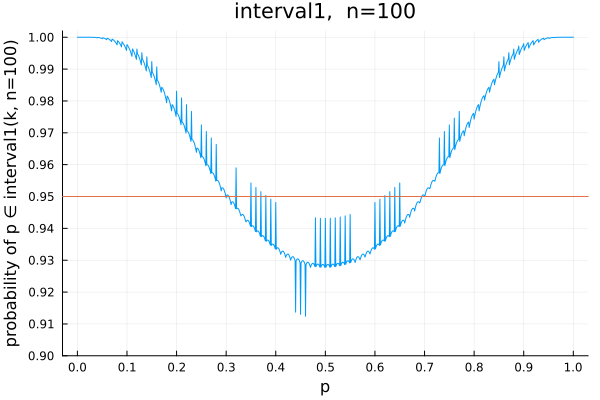

In [3]:
n = 100
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval1, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ interval1(k, n=$n)")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("interval1,  n=$n")

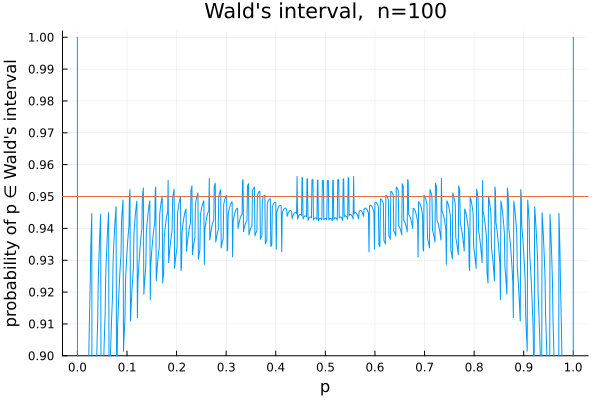

In [4]:
n = 100
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval_wald, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ Wald's interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Wald's interval,  n=$n")

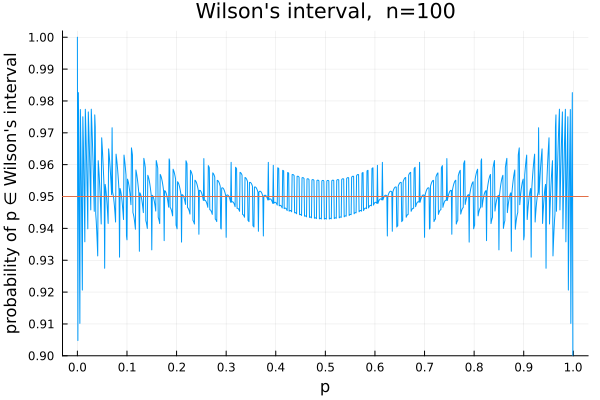

In [5]:
n = 100
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval_wilson, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ Wilson's interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Wilson's interval,  n=$n")

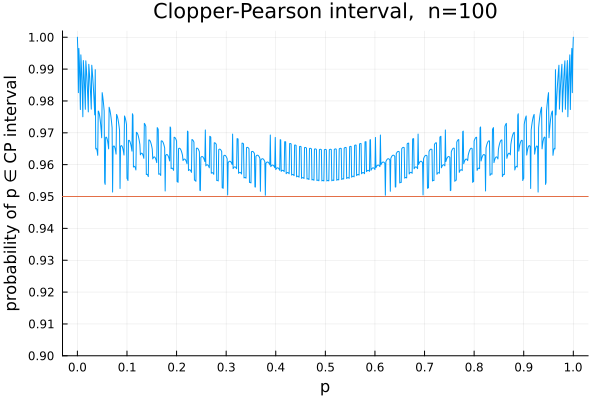

In [6]:
n = 100
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval_clopper_pearson, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ CP interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Clopper-Pearson interval,  n=$n")

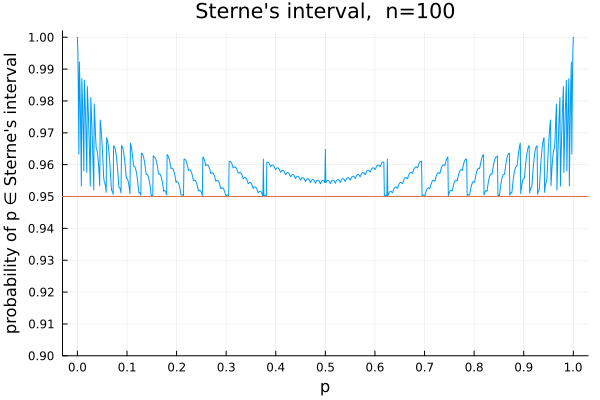

In [7]:
n = 100
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval_sterne(n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ Sterne's interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Sterne's interval,  n=$n")

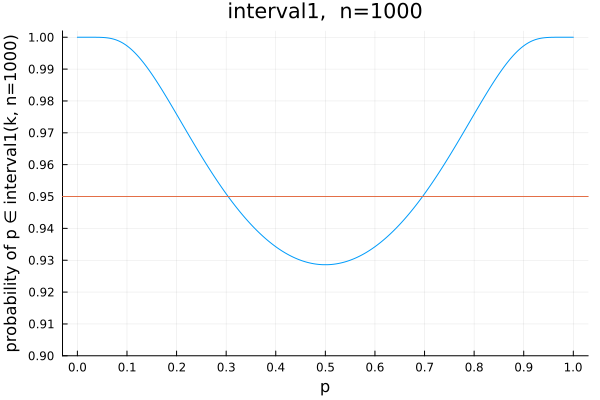

In [8]:
n = 1000
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval1, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ interval1(k, n=$n)")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("interval1,  n=$n")

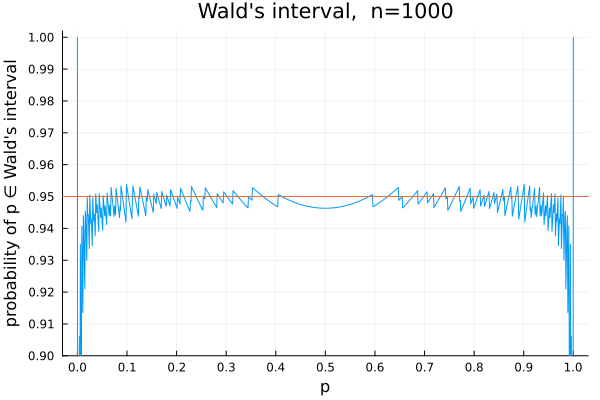

In [9]:
n = 1000
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval_wald, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ Wald's interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Wald's interval,  n=$n")

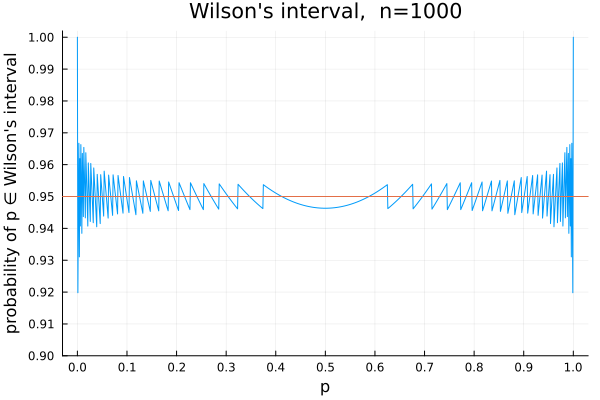

In [10]:
n = 1000
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval_wilson, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ Wilson's interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Wilson's interval,  n=$n")

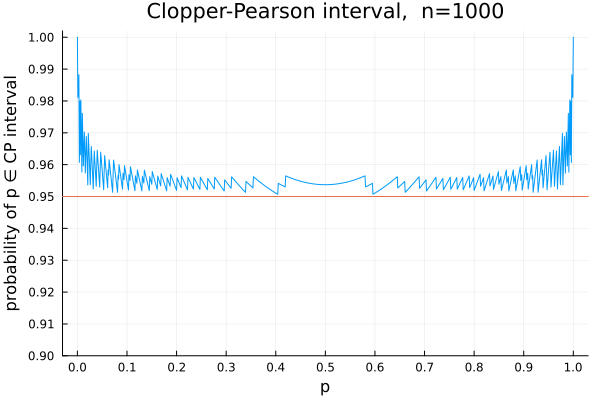

In [11]:
n = 1000
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval(interval_clopper_pearson, n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ CP interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Clopper-Pearson interval,  n=$n")

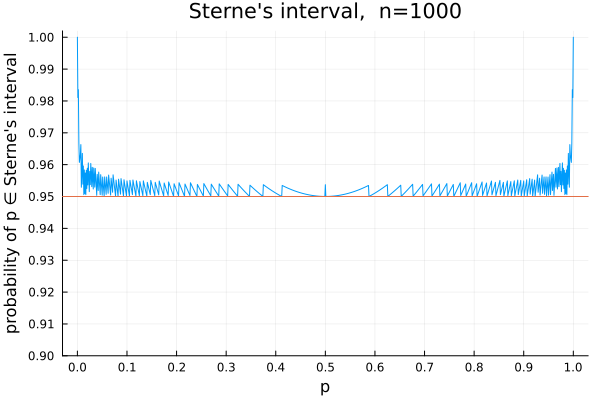

In [12]:
n = 1000
p = range(0, 1, 1001)
plot(p, p -> prob_p_in_interval_sterne(n, p); label="")
plot!(xguide="p", yguide="probability of p ∈ Sterne's interval")
plot!(ylim=(0.9, 1.002), ytick=0:0.01:1, xtick=0:0.1:1)
hline!([0.95]; label="")
title!("Sterne's interval,  n=$n")